# TensorFlow for ICT Applications

## Lab session 4: Convolutional networks

**Contents of this lab session:**

1. Loading image data with Keras.
2. Downloading a custom model and fine-tuning it.

### Downloading the dataset and setting up the virtual machine

**Important**: this section is only needed if you are running a Google Colaboratory virtual environment.

Download the "EUROSat" dataset from here: http://madm.dfki.de/downloads

In [1]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip

--2019-05-10 09:08:50--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  21.0MB/s    in 5.5s    

2019-05-10 09:08:56 (16.3 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [0]:
!unzip -q EuroSAT.zip 

In [ ]:
!ls # Data should be in the '2750' folder

In [ ]:
!pip install tensorflow-gpu==2.0.0-beta1

### Loading image data in Keras

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

See here for the full documentation of the Keras image generator: https://keras.io/preprocessing/image/.

Alternatively, we could have loaded images using tf.data, but in the case of separated folders using the Keras interface is slightly easier: https://www.tensorflow.org/tutorials/load_data/images.

In [2]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1.0/255)

In [3]:
dataset_path = './data/eurosat/' # Substitute with your folder or '2750' in Google Colab

In [15]:
train_data = train_datagen.flow_from_directory(dataset_path, target_size=(64, 64), batch_size=32, subset='training')
test_data = train_datagen.flow_from_directory(dataset_path, target_size=(64, 64), batch_size=32, subset='validation')

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


Desired target for the image is:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


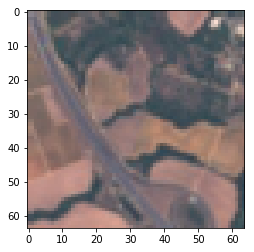

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
for xb, yb in train_data:
    plt.imshow(xb[0, :, :, :])
    print('Desired target for the image is: ', yb[0])
    break

In [8]:
# To understand the link between integers and classes
train_data.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

### Downloading a pretrained model in Keras

https://www.tensorflow.org/api_docs/python/tf/keras/models/Model

In [9]:
from tensorflow.keras import applications
vgg = applications.vgg19.VGG19(include_top=False, input_shape=(64, 64, 3))

In [10]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [11]:
# Make all layers non-trainable (i.e., "freeze" the layers)
for l in vgg.layers:
    l.trainable = False

In [12]:
from tensorflow.keras import models, layers

In [13]:
# Add a single layer for classification
model = models.Sequential()

model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,044,874
Trainable params: 20,490
Non-trainable params: 20,024,384
_________________________________________________________________


### Training the model with Keras high-level interface

In [17]:
import numpy as np
# When using generators, we need to manually specify the duration of an epoch
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size)
test_steps = np.ceil(test_data.samples/test_data.batch_size)

In [18]:
# We will use a callback to make some temporary checkpoints
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath='checkpoints/model-{epoch:02d}.ckpt', 
                                      save_weights_only=True, # Only saves the weights (not the model structure)
                                      verbose=1)

In [19]:
# We will use another callback to visualize progress on the external TensorBoard utility
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir='tensorboard_logs', update_freq='batch')

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [24]:
history = model.fit_generator(
    train_data,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
    callbacks=[checkpoint_callback, tensorboard_callback] # Note the callbacks here
)

Epoch 1/2


W0614 12:49:52.859266 11896 deprecation.py:323] From C:\Users\Simone\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


674/675 [============================>.] - ETA: 0s - loss: 0.8893 - accuracy: 0.7028
Epoch 00001: saving model to checkpoints/model-01.ckpt
675/675 [==============================] - 357s 530ms/step - loss: 0.8888 - accuracy: 0.7030
Epoch 2/2
674/675 [============================>.] - ETA: 0s - loss: 0.6163 - accuracy: 0.7922
Epoch 00002: saving model to checkpoints/model-02.ckpt
675/675 [==============================] - 177s 262ms/step - loss: 0.6159 - accuracy: 0.7923


In [ ]:
# You can play with the Tensorboard while it is training

# From a local machine, open a new terminal and write:
# >> tensorboard --logdir tensorboard_logs
# Then, you can connect to the URL shown in the output

# From Google Colab, load the TensorBoard extension:
# %load_ext tensorboard
# Now you can launch the TensorBoard directly inside the notebook:
# %tensorboard --logdir tensorboard_logs

### Reload the latest checkpoint

In [25]:
import tensorflow as tf
latest_checkpoint = tf.train.latest_checkpoint('checkpoints')
print(latest_checkpoint)

checkpoints\model-02.ckpt


In [26]:
model.load_weights(latest_checkpoint)

In [30]:
# Evaluate on the test data
test_values = model.evaluate_generator(test_data, steps=test_steps)

In [36]:
print('Test loss is {:.2f}, test accuracy is {:.2f} %'.format(test_values[0], test_values[1] * 100))

Test loss is 0.59, test accuracy is 79.61 %
